In [905]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import numpy as np
import string
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.linear_model import LinearRegression

# nltk.download('wordnet') # Required for lemmatization
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')

In [906]:
#-----------------------------------------------
# Goal
# - Clean Amazon eCommerce data
# - Conduct Exploratory Data Analysis
# - Conduct Keyword Analysis
#-----------------------------------------------

file = 'OneDrive/Desktop/Portfolio/Amazon best sellers v2.csv'
df = pd.read_csv(file, encoding='unicode_escape')
df = df[df.filter(regex='^(?!Unnamed)').columns]

In [ ]:
#----------------------------------------------------------------------------
# Function StripAccent(thestring As String)
# Dim A As String * 1
# Dim B As String * 1
# Dim i As Integer
# Const AccChars= "áäčďéěíĺľňóôőöŕšťúůűüýřžÁÄČĎÉĚÍĹĽŇÓÔŐÖŔŠŤÚŮŰÜÝŘŽ"
# Const RegChars= "aacdeeillnoooorstuuuuyrzAACDEEILLNOOOORSTUUUUYRZ"
# For i = 1 To Len(AccChars)
# A = Mid(AccChars, i, 1)
# B = Mid(RegChars, i, 1)
# thestring = Replace(thestring, A, B)
# Next
# StripAccent = thestring
# End Function
#-----------------------------------------------------------------------------

#-------------------------------------------------------------------------------------
# The excel file was riddles with diacritics, which messed w/ the keyword analysis
# Above is the script used in VBA to get rid of them all
# 
# credit to mpecka/ExcelRemoveAccents.vb
# 
#-------------------------------------------------------------------------------------

In [907]:
def check(df):
    list=[]
    for col in df.columns:
        columns = df.columns
        dtype = df[col].dtypes
        instances = df[col].count()
        unique = df[col].nunique()
        sum_null = df[col].isnull().sum()
        duplicates = df[col].duplicated().sum()
        list.append([dtype,instances,unique,sum_null,duplicates])
    data_check = pd.DataFrame(list,columns=["dtype","instances","unique","sum_null","duplicates"],index=df.columns)
    return data_check

In [871]:
def check_unique(df):
    nunique=df.apply(lambda col: col.nunique())
    unique_values = df.apply(lambda col: col.unique())
    data_check = pd.DataFrame({'uni_count': nunique, 'unique_values': unique_values})
    return data_check

In [872]:
def check_missing(df):
    values = df.isnull().sum()
    percentage = (values/len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': values, 'Percentage (%)': percentage})
    return missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False) 

In [873]:
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]

In [874]:
#---------------------------------------#
# This method is having issues          #
# - Will have to return to this later   #
#                                       #
#---------------------------------------#

def drop_outliers(dataframe, column): 
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
 
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(dataframe[column] >= upper_bound)[0]
    lower_array = np.where(dataframe[column] <= lower_bound)[0]
 
    # Removing the outliers
    dataframe.drop(index=upper_array, axis=1, inplace=True)
    dataframe.drop(index=lower_array, axis=1, inplace=True)

In [910]:
#------------------------------------------------------------------------------------------------------------------------
# Reasons for dropping columns
# - currency
#   > Everything is in USD already, so this is redundant
# - asin, parent_asin, input_asin
#   > We aren't using asin for Data Analysis or Keyword Analysis, so we'll drop it
# - domain
#   > Everything is hosted on Amazon.com, so this is redundant
# - url, image_url, image
#   > In another excercise it makes sense to run keyword analysis, but for this project we're just going to focus on 
#     descriptions and top_review
# - item_weight, product_dimensions, seller_id, model_number, upc, variations, features, buybox_prices
#   > Unnecessary
# - final_price_high, format
#   > Blank, so we'll just remove it
#------------------------------------------------------------------------------------------------------------------------

df.drop(["currency",
         "asin",
         "parent_asin",
         "input_asin",
         "domain",
         "url",
         "image_url",
         "image",
         "item_weight",
         "product_dimensions",
         "seller_id",
         "model_number",
         "upc",
         "variations",
         "features",
         "buybox_prices",
         "final_price_high",
         "format"],axis=1,inplace=True)

In [912]:
check_missing(df)

,Missing Values,Percentage (%)
department,817,81.7
seller_name,187,18.7
initial_price,165,16.5
top_review,135,13.5
buybox_seller,56,5.6
answered_questions,28,2.8
description,25,2.5
date_first_available,19,1.9
number_of_sellers,11,1.1
manufacturer,9,0.9


In [913]:
#-------------------------------------
# Dropping 'department' because there's over 75% missing
#-------------------------------------
df.drop(["department"],axis=1,inplace=True)

In [914]:
check_missing(df)

,Missing Values,Percentage (%)
seller_name,187,18.7
initial_price,165,16.5
top_review,135,13.5
buybox_seller,56,5.6
answered_questions,28,2.8
description,25,2.5
date_first_available,19,1.9
number_of_sellers,11,1.1
manufacturer,9,0.9
root_bs_rank,4,0.4


In [915]:
#------------------------------------------------------------------------------------------------------------#
# Even though we're cleaned up the dataset, there are still some columns with missing values                 #  
# - Need to figure out whether to keep them or drop them based on their relevance                            #
#                                                                                                            #
# To handle this, we will implement the following workarounds:                                               #
# 1. For categorical columns w/ missing values, we will replace missing values with Unknown                  #
# 2. For numerical columns w/ missing values, we will replace missing values with the mean of the column     #
#                                                                                                            #
#------------------------------------------------------------------------------------------------------------#

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(exclude=['object']).columns

# Replace missing values
for column in categorical_columns:
    df[column].fillna('Unknown', inplace=True)

for column in numerical_columns:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [916]:
df["plus_content"] = df["plus_content"].astype(int)
df["video"] = df["video"].astype(int)
df["free delivery"] = df["free delivery"].astype(int)

In [917]:
check_missing(df)

,Missing Values,Percentage (%)


In [918]:
#----------------------------------------------------------------------------------------------------------
# Outliers can skew the results of our analysis, so it’s essential to identify and handle them appropriately. 
# One common method to identify outliers is by using the Interquartile Range (IQR). 
# We’ll use this method to detect outliers for numerical columns and decide how to handle them.
#--------------------------------------------------------------------------------------------------------------
outliers_data = {}
for column in numerical_columns:
    outliers = detect_outliers(df, column)
    outliers_data[column] = len(outliers)

outliers_data

{'initial_price': 95,
 'reviews_count': 90,
 'number_of_sellers': 67,
 'root_bs_rank': 62,
 'answered_questions': 36,
 'images_count': 207,
 'video_count': 203,
 'rating': 75,
 'discount': 0,
 'plus_content': 0,
 'video': 183,
 'final_price': 115,
 'free delivery': 0}

In [919]:
df.shape

(1000, 24)

In [920]:
Q1 = df['reviews_count'].quantile(0.25)
Q3 = df['reviews_count'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(df['reviews_count'] >= upper)[0]
lower_array = np.where(df['reviews_count'] <= lower)[0]
 
# Removing the outliers
df.drop(index=upper_array, axis=1, inplace=True)
df.drop(index=lower_array, axis=1, inplace=True)

In [921]:
df.shape

(898, 24)

In [922]:
descriptive_stats = df.describe(include=[float, int])
descriptive_stats

,initial_price,reviews_count,number_of_sellers,root_bs_rank,answered_questions,images_count,video_count,rating,discount,plus_content,video,final_price,free delivery
count,898.000000,898.000000,898.000000,8.980000e+02,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000
mean,82.506697,3.566815,3.840930,7.798200e+05,4.784643,1.926503,0.293987,3.474388,0.111247,0.605791,0.174833,100.380947,0.210468
std,130.705587,2.642693,4.545244,1.151059e+06,4.728566,2.179552,0.768954,1.189845,0.116797,0.488953,0.380036,248.292700,0.407868
min,3.160000,1.000000,0.000000,2.600000e+01,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.290000,0.000000
25%,20.037500,1.000000,1.000000,1.632415e+05,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,14.990000,0.000000
50%,46.635000,3.000000,2.000000,4.199480e+05,4.000000,1.000000,0.000000,4.000000,0.100000,1.000000,0.000000,30.990000,0.000000
75%,80.467425,5.000000,4.000000,9.901605e+05,8.000000,1.000000,0.000000,4.000000,0.200000,1.000000,0.000000,84.097500,0.000000
max,1535.950000,11.000000,43.000000,1.349528e+07,30.000000,14.000000,6.000000,5.000000,0.300000,1.000000,1.000000,3480.750000,1.000000


C:\Users\Dustin\AppData\Local\Temp\ipykernel_12488\2977627592.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



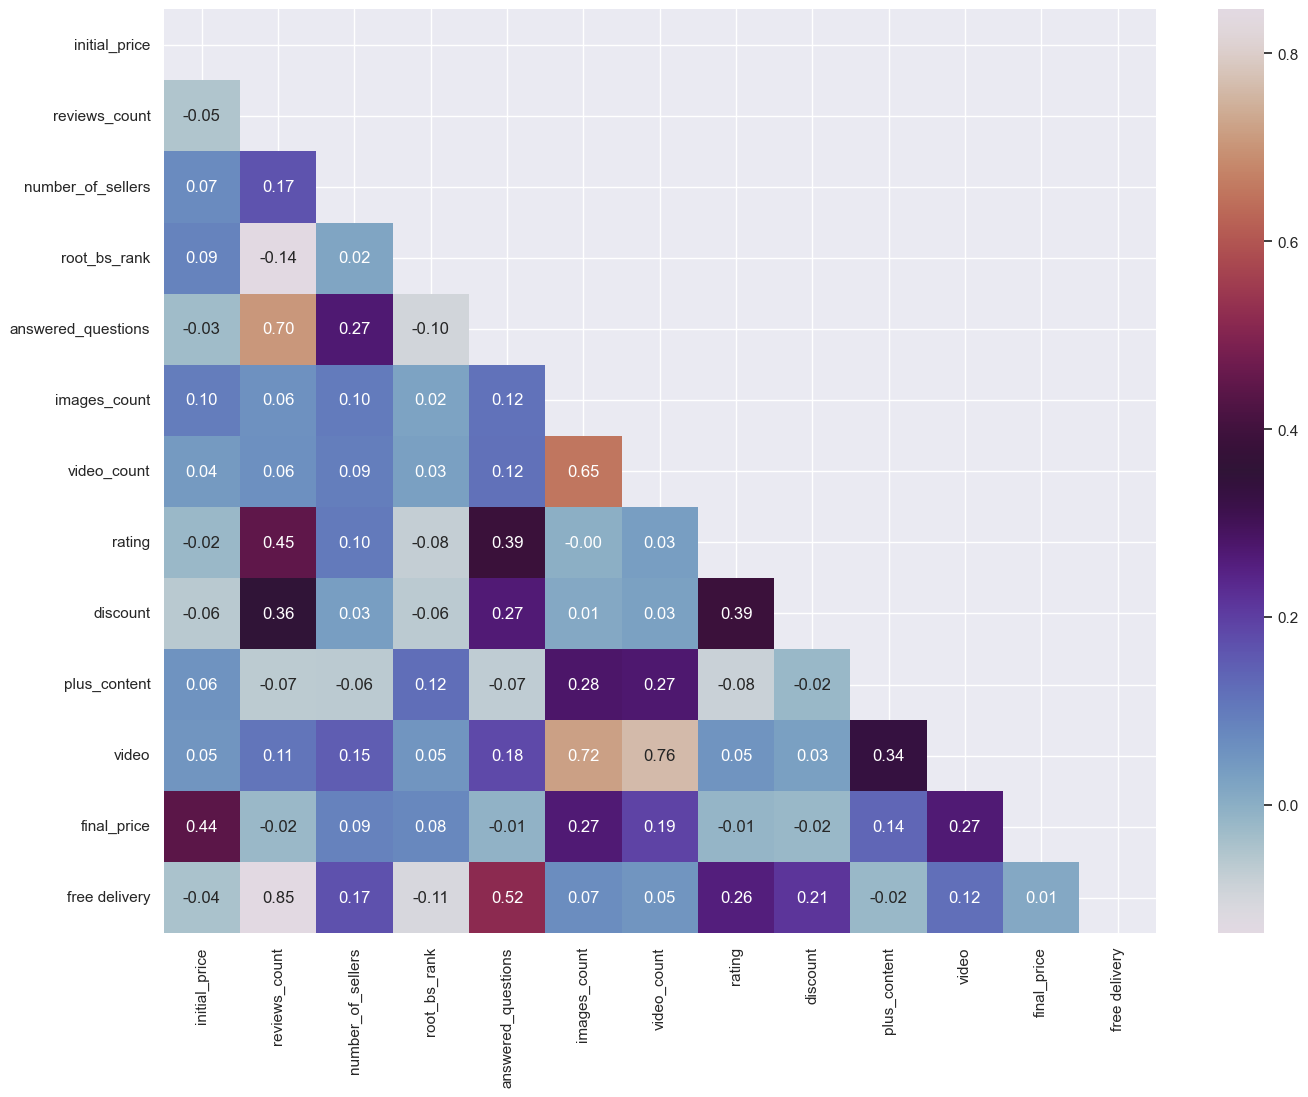

In [923]:
sns.set(rc={'figure.figsize':(16,12)})
corr = df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(np.ones_like(corr))
# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, fmt='.2f', mask=matrix, cmap="twilight")
plt.show()

In [924]:
#---------------------------------------------
# Factors that affect rating
# - reviews_count
# - number_of_sellers
# - answered_questions
#---------------------------------------------

<Figure size 1000x500 with 0 Axes>

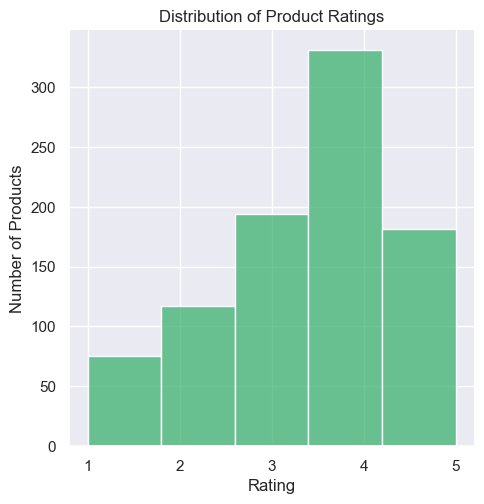

In [925]:
# Set the style for seaborn
sns.set_style("darkgrid")

# Plot the distribution of book ratings
plt.figure(figsize=(10, 5))
sns.displot(df['rating'], bins = 5, kde=False, color='mediumseagreen')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Products')
plt.show()

In [926]:
fig = px.scatter(df, x="rating", y="reviews_count", trendline="ols", trendline_color_override="red")
fig.show()

results = px.get_trendline_results(fig)

In [927]:
fig = px.scatter(df, x="rating", y="answered_questions", trendline="ols", trendline_color_override="red")
fig.show()

results = px.get_trendline_results(fig)

In [928]:
fig = px.scatter(df, x="rating", y="number_of_sellers", trendline="ols", trendline_color_override="red")
fig.show()

results = px.get_trendline_results(fig)

In [953]:
# Instantiate
lemmatizer = WordNetLemmatizer()
# Create our own stop words
stop_words = ("0o", "0s", "3a", "3b", "3d", "6b", "6o", 
              "a", "a1", "a2", "a3", "a4", "ab", "able", 
              "about", "above", "abst", "ac", "accordance", "according", 
              "accordingly", "across", "act", "actually", "ad", "added", 
              "adj", "ae", "af", "affected", "affecting", "affects", "after", 
              "afterwards", "ag", "again", "against", "ah", "ain", "ain't", 
              "aj", "al", "all", "allow", "allows", "almost", "alone", "along", 
              "already", "also", "although", "always", "am", "among", "amongst", 
              "amoungst", "amount", "an", "and", "announce", "another", "any", 
              "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", 
              "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", 
              "appreciate", "appropriate", "approximately", "ar", "are", "aren", 
              "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", 
              "asking", "associated", "at", "au", "auth", "av", "available", "aw", 
              "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", 
              "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", 
              "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", 
              "being", "believe", "below", "beside", "besides", "best", "better", "between", 
              "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", 
              "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", 
              "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", 
              "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", 
              "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", 
              "consequently", "consider", "considering", "contain", "containing", "contains", 
              "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", 
              "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2",
              "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", 
              "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", 
              "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", 
              "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", 
              "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere",
              "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", 
              "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", 
              "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", 
              "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", 
              "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", 
              "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", 
              "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", 
              "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", 
              "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", 
              "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", 
              "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", 
              "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", 
              "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", 
              "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", 
              "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", 
              "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", 
              "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", 
              "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", 
              "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", 
              "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", 
              "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", 
              "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", 
              "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", 
              "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", 
              "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", 
              "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", 
              "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", 
              "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", 
              "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", 
              "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", 
              "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", 
              "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", 
              "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", 
              "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", 
              "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", 
              "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", 
              "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", 
              "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", 
              "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", 
              "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", 
              "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", 
              "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", 
              "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", 
              "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", 
              "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", 
              "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", 
              "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", 
              "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", 
              "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", 
              "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", 
              "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", 
              "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", 
              "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", 
              "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", 
              "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", 
              "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", 
              "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", 
              "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", 
              "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", 
              "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", 
              "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", 
              "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", 
              "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", 
              "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", 
              "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", 
              "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", 
              "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", 
              "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", 
              "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", 
              "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", 
              "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", 
              "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", 
              "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", 
              "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", 
              "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz", 
              "product", "design", "tool", "type", "material", "ha", "feature", "size", "color", "inch", "mm", "unknown")
# Exclusion list of punctuations and numbers
exclist = string.punctuation + string.digits
# Print the exclusion list
print(exclist)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789


In [954]:
# Create a Function
def clean_texts(text):
    """ Function to perform preprocessing """
    
    # Convert to lower cases
    text = text.lower()
    
    # Remove punctuations and numbers
    text = text.translate(str.maketrans("", "", exclist))
    
    # Replace certain words
    text = text.replace("leased", "lease")
    
    # Tokenization
    tokens = word_tokenize(text)
        
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens
    clean_text = " ".join(tokens)
    
    # Return the output
    return clean_text
# Apply the function to all disclosures
df['description'] = df['description'].apply(clean_texts)
df['top_review'] = df['top_review'].apply(clean_texts)
# View the first 5 rows
df.head()

,title,seller_name,brand,description,initial_price,availability,reviews_count,categories,buybox_seller,number_of_sellers,...,rating,date_first_available,discount,manufacturer,plus_content,video,top_review,final_price,free delivery,timestamp
102,Great Eastern Entertainment Sailor Moon S Plut...,Kawaii-World,Great Eastern Entertainment,officially licensed authentic sailor moon plut...,11.950000,Only 1 left in stock - order soon,11,"Cell Phones & Accessories, Accessories, Deco...",Kawaii-World,4.0,...,3,11/1/2012,0.1,Great Eastern Entertainment,0,0,fan main sailor scout symbol lucky gfs favorit...,11.10,1,9/10/2023
103,DEWALT 28598000 Gauge Blade Setting,PowerToolReplacementParts,Dewalt,fit dewalt model oem authorized oem number man...,15.580000,In Stock,11,"Tools & Home Improvement, Power & Hand Tools,...",PowerToolReplacementParts,3.0,...,3,5/8/2015,0.1,Dewalt,0,0,work,14.34,1,9/11/2023
104,Wiha 96105 Phillips Screwdriver with Precision...,Amazon.com,Wiha,wiha phillips screwdriver precision handle bla...,80.467425,In Stock,11,"Tools & Home Improvement, Power & Hand Tools,...",Amazon.com,3.0,...,4,12/17/2004,0.1,WIHA,1,0,buying brand dont destroyed screw screw damage...,8.49,1,9/11/2023
105,Weller Xcelite 170MN ESD Safe Shear Cutter - G...,Amazon.com,Weller,weller xcelite low profile generalpurpose cutt...,18.290000,In Stock,11,"Tools & Home Improvement, Power & Hand Tools,...",Amazon.com,4.0,...,4,6/16/2021,0.2,Weller,0,0,jewelry accessory work great,16.87,1,9/11/2023
106,INTIMO Miraculous: Tales of Ladybug & Cat Noir...,PJammy,Intimo,modernday paris marinette adrien high school k...,26.950000,In Stock,11,"Clothing, Shoes & Jewelry, Girls, Clothing...",PJammy,2.0,...,3,8/25/2022,0.0,Intimo,1,0,shes bought,19.95,1,10/6/2023


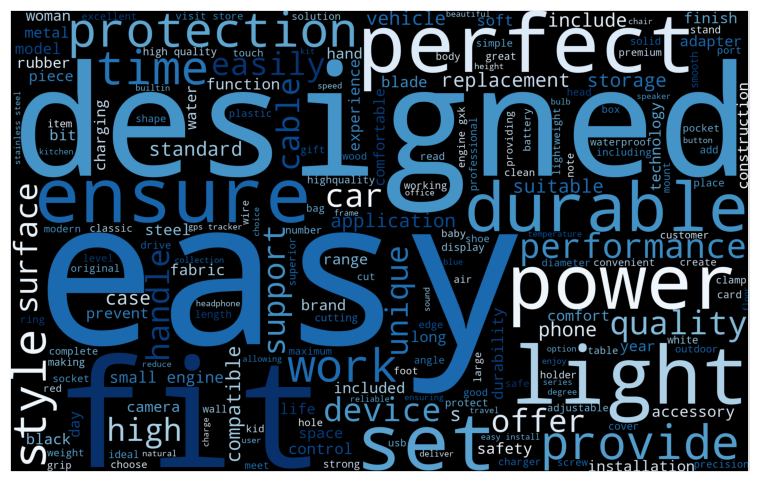

In [955]:
wc = WordCloud(width=2400,
               height=1500,
               min_font_size=10,
               colormap="Blues",
               background_color='black')
# Generate a word cloud
plt.figure(figsize = (24, 6))
lease_wc = wc.generate(df['description'].str.cat(sep=" "))
plt.xticks([])
plt.yticks([])
plt.imshow(lease_wc)
plt.show()

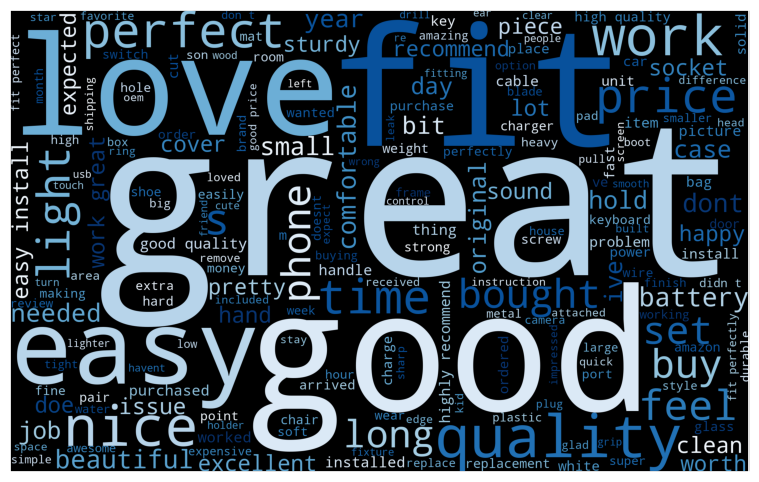

In [956]:
wc = WordCloud(width=2400,
               height=1500,
               min_font_size=10,
               colormap="Blues",
               background_color='black')
# Generate a word cloud
plt.figure(figsize = (24, 6))
lease_wc = wc.generate(df['top_review'].str.cat(sep=" "))
plt.xticks([])
plt.yticks([])
plt.imshow(lease_wc)
plt.show()

C:\Users\Dustin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 156 (\x9c) missing from current font.

C:\Users\Dustin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 147 (\x93) missing from current font.

C:\Users\Dustin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 148 (\x94) missing from current font.



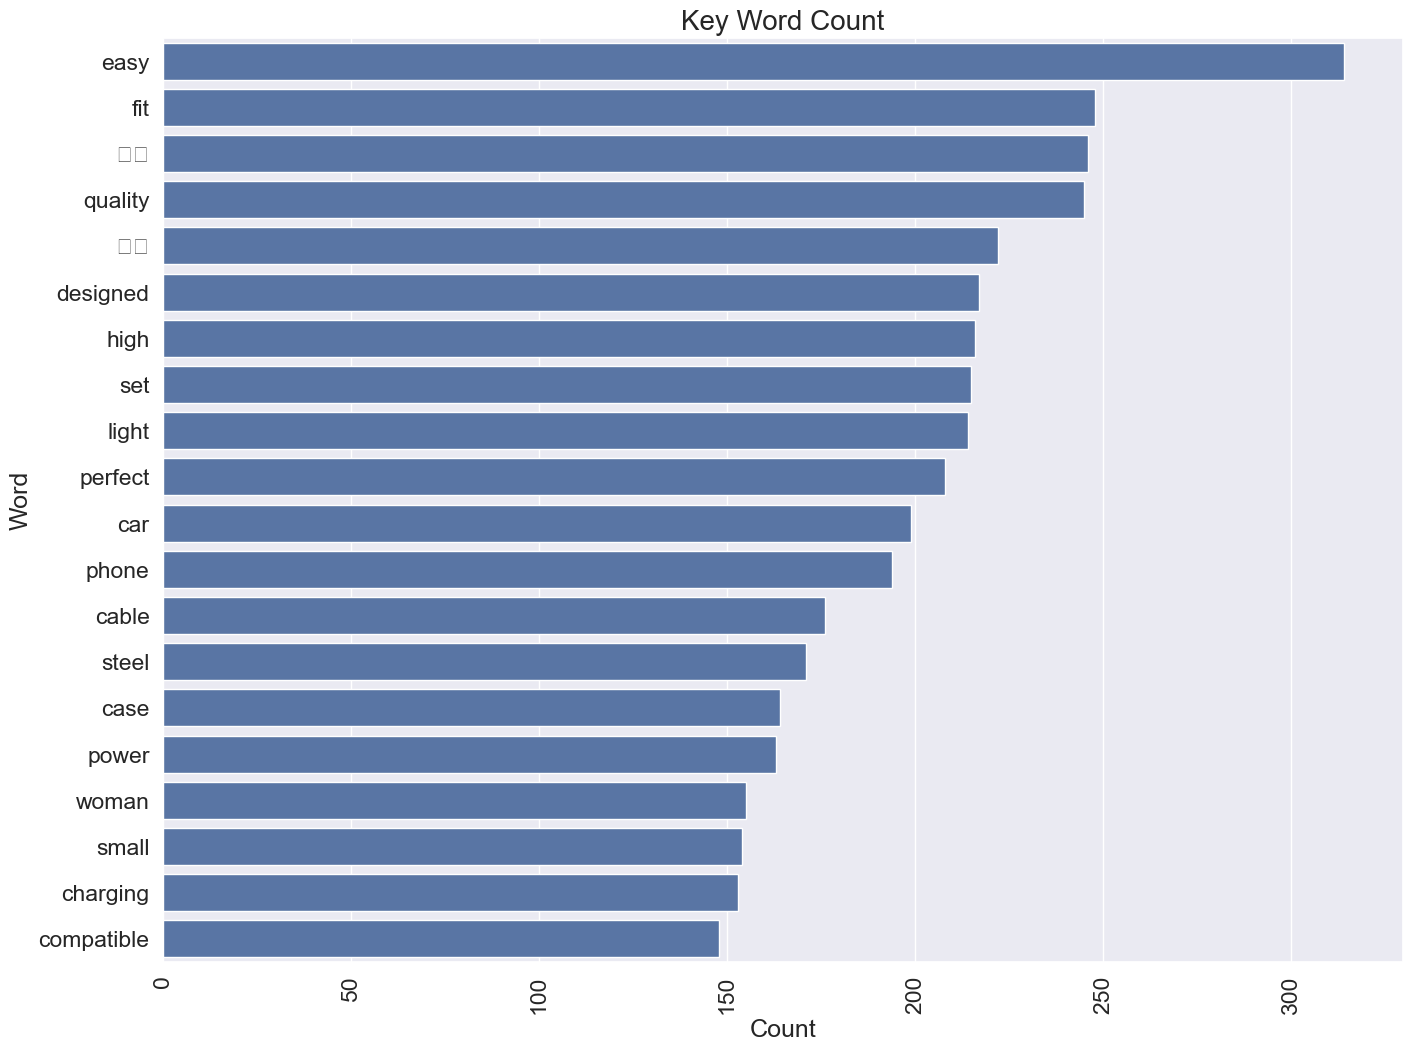

In [957]:
# Bar plot - Create a corpus of disclosures
corpus = []
for disclosures in df['description'].tolist():
    for word in disclosures.split():
        corpus.append(word)
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus).most_common(20))
common_words.columns = ('Word', 'Count')
# Plot a bar chart of the most common 20 words
sns.set(font_scale = 1.5)
sns.barplot(x= common_words['Count'], y=common_words['Word'])
plt.xticks(rotation='vertical')
plt.title("Key Word Count", fontsize = 20)
plt.show()

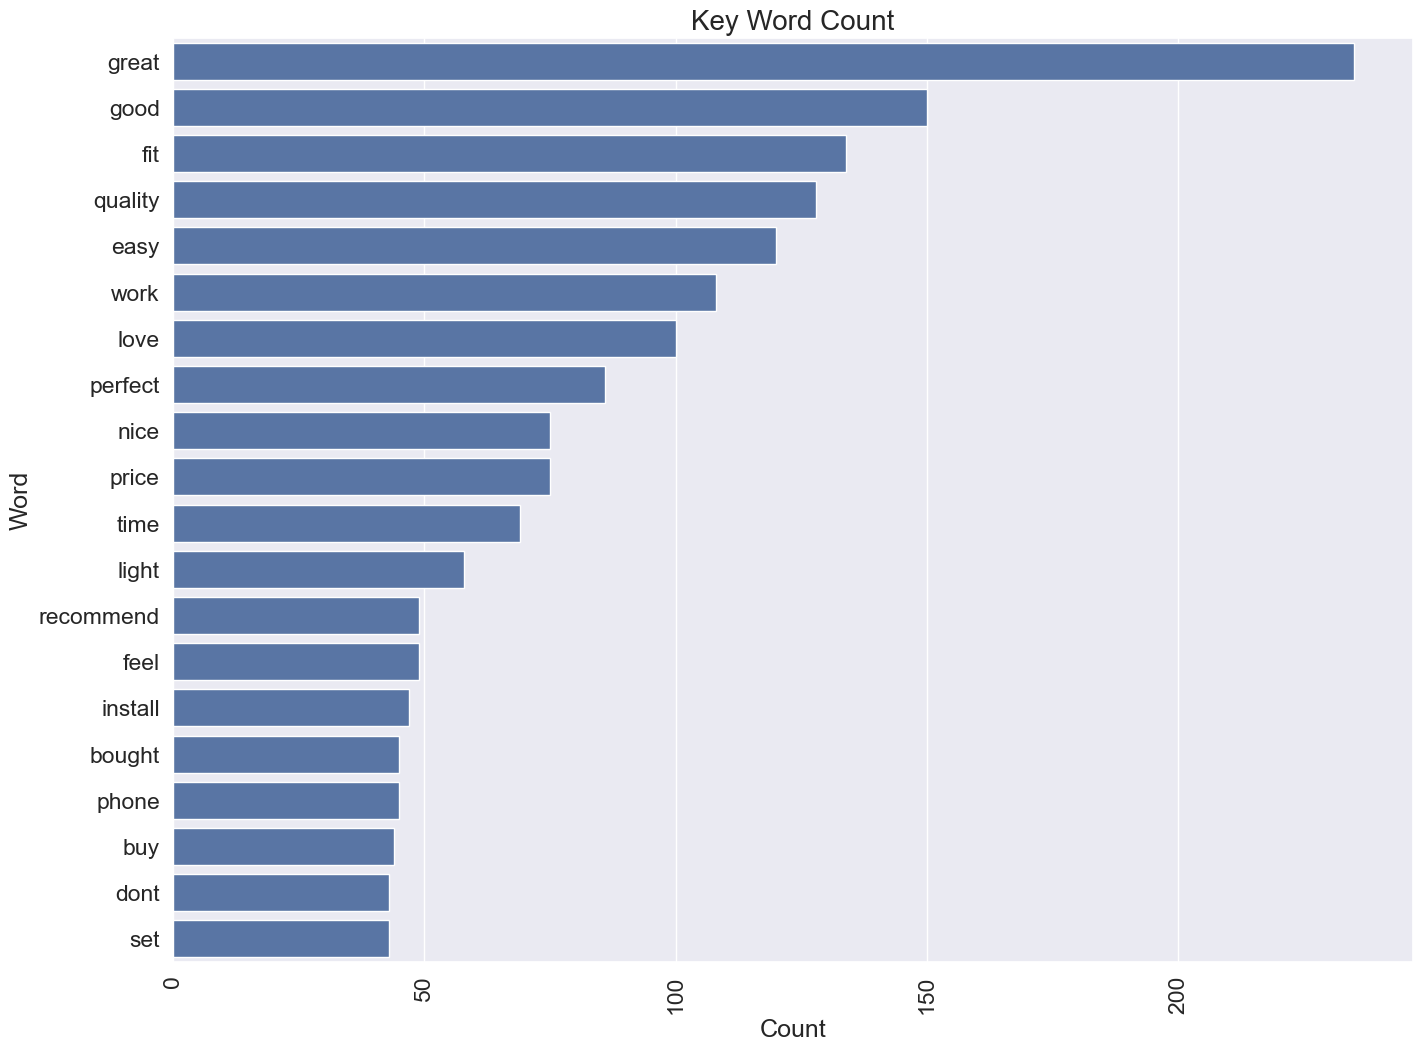

In [958]:
# Bar plot - Create a corpus of disclosures
corpus = []
for disclosures in df['top_review'].tolist():
    for word in disclosures.split():
        corpus.append(word)
# Bar plot - Create a dataframe of the most common 30 words
common_words = pd.DataFrame(Counter(corpus).most_common(20))
common_words.columns = ('Word', 'Count')
# Plot a bar chart of the most common 20 words
sns.set(font_scale = 1.5)
sns.barplot(x= common_words['Count'], y=common_words['Word'])
plt.xticks(rotation='vertical')
plt.title("Key Word Count", fontsize = 20)
plt.show()